# <style> 
    .ma-classe {
    font-size: 40 px;
}
</style>
<div class="alert alert-warning">  Load Librairies </div>


In [1]:
import torch

In [2]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import torch.nn as nn
from torch import tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import torchvision
from torchvision import utils
import torchvision.transforms as transforms

from tqdm import tqdm 

from PIL import Image, ImageDraw
import plotly.graph_objs as go

In [3]:
import conf_matrix
from conf_matrix import make_confusion_matrix
from sklearn import metrics

#  <style> 
    .ma-classe {
    font-size: 40px;
}
</style>
<div class="alert alert-danger">1 |</span></b> Load the data </div>

In [4]:
ORIGINAL = "data/original_data/"
TRAIN_DIR = ORIGINAL + "mut_effect_train.csv"
TEST_DIR = ORIGINAL + "mut_effect_test.csv"
VAL_DIR =  ORIGINAL + "mut_effect_validation.csv"
UNIPROT_DIR = ORIGINAL + "uniprot_fasta_sequences.csv"

In [5]:
mut_effect_train = pd.read_csv(TRAIN_DIR)
mut_effect_test = pd.read_csv(TEST_DIR)
mut_effect_val = pd.read_csv(VAL_DIR)

uniprot_seq = pd.read_csv(UNIPROT_DIR)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success"> Exploration of the data</div>


#  <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">1.1.1 |</span></b> Display the original data  </div>

mut_effect_train, mut_effect_test and mut_effect_test have the same structure. They formed the dataset already divided in three distincts parts : training, testing, validation. 
Here we display the train set. 

In [6]:
mut_effect_train

,uniprot,ftype,pos,ori_res,var_res,desc,no effect,length
0,Q2G160,mutagenesis site,165,K,C,"3125-fold decrease in catalytic activity, and ...",False,293
1,O33599,mutagenesis site,117,N,A,Activates the enzyme.,False,316
2,O33599,mutagenesis site,210,H,A,Inactivates the enzyme.,False,316
3,O33599,mutagenesis site,214,D,A,Inactivates the enzyme.,False,316
4,O33599,mutagenesis site,291,H,A,Inactivates the enzyme.,False,316
...,...,...,...,...,...,...,...,...
46387,C6KT50,mutagenesis site,139,R,A,No activity; when associated with A-136 and A-...,False,301
46388,C6KT50,mutagenesis site,140,R,A,No activity; when associated with A-136 and A-...,False,301
46389,C6KT50,mutagenesis site,151,K,A,No activity. The mutant forms hexamers instead...,False,301
46390,Q8ILG2,mutagenesis site,246,D,A,Loss of catalytic activity.,False,627


The uniprot data contains the correspondences between the uniprot code of the studied proteins and their sequences. 

In [7]:
uniprot_seq

,uniprot,sequence
0,K0F8Z5,MSSEKIQRVGIIGAGQMGAGIAEVCARAHVDVLVYEQTRELAAAGR...
1,K0F1Z7,MTRHVDVLIIGAGLSGIGMACHLTREQTGRSYAILERRAAIGGTWD...
2,K0EI02,MPKARATALITAALIVVVLVAGCTRLVDGRAVSIYDDPFKVAGLPT...
3,K0EPK0,MYSPIEDWDTDEVWMFLMQYANPWGVSNKDLLTMYQGASADSECPL...
4,K0EQ80,MTEASADAAGARRRRNRDIAGRHVLITGASSGIGRAAAIAVAGKGA...
...,...,...
333188,A0A2K6VSY6,MSGWAAYIKNLLDSSQGIQRAAIVGYPDGAVWARSEGDREFRATDE...
333189,A0A044S2V0,MFCNCPCIRWDKLFNTVSSRNKVNVIKGGSKSVMLSVPQTSQTGRP...
333190,A0A158N8U1,MSLIIPEKFQHIHRVMNTNIDGNRKVPFALTAIKGVGRRFAFVVCR...
333191,A0A044TE30,MSKLQEISEQIDFSAEELKILEWWRERKTFAKSLELSKGRTRYTFY...


#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success"> New dataset</div>

In order to exploit the data show above, we first extracted the sequences corresponding to the uniprot codes from the dataset "uniprot_seq". Then, thanks to the differents features provided in the original dataset we were able to reconstruct the sequence after mutation. 
Moreover, for each protein we have kept in the last column: the original amino acid, the amino acid that replaced it and finally the position of the mutation in the sequence. This column allowed us to further analyze the performance of our models to see if there was a correlation between a good prediction and the mutated amino acid. 
Finally, the y column corresponds to the label of our model. A 1 means that the mutation had no effect and a 0 the opposite. 


In [8]:
NEW = "data/extracted_data/"

TRAIN_600 = NEW + "train_600.csv"
TRAIN_215 = NEW + "train_215.csv"
VAL_600 = NEW + "val_600.csv"
VAL_215 = NEW + "val_215.csv"

In [9]:
data_train_600 = pd.read_csv(TRAIN_600)
data_val_600 = pd.read_csv(VAL_600)
data_train_215 = pd.read_csv(TRAIN_215)
data_val_215 = pd.read_csv(VAL_215)

In [10]:
data_train_600

,sequence,sequence_mutated,sequence_mask,Y,amino_info
0,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,1,"('K', 'A', 264)"
1,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,1,"('W', 'A', 75)"
2,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,0,"('H', 'A', 113)"
3,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,1,"('T', 'A', 365)"
4,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,0,"('E', 'Q', 59)"
...,...,...,...,...,...
4495,MVNPTTSEVQPTMGVKIFSAGVSACLADIITFPLDTAKVRLQIQGE...,MVNPTTSEVQPTMGVKIFSAGVSAALADIITFPLDTAKVRLQIQGE...,MVNPTTSEVQPTMGVKIFSAGVSA?LADIITFPLDTAKVRLQIQGE...,1,"('C', 'A', 25)"
4496,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,0,"('D', 'A', 75)"
4497,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,0,"('A', 'S', 71)"
4498,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,0,"('D', 'V', 76)"


#  <style> 
    .ma-classe {
    font-size: 40px;
}
</style>
<div class="alert alert-danger">2 |</span></b> Residual NN and CNN  </div>

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.1 |</span></b> Preprocessing </div>

#  <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.1.1 |</span></b> Integer encoding </div>

There are 20 different amino acids that can compose our sequences. For each amino acid, an integer has been associated. The sequence of amino acids has been transformed into a sequence of integers.
First we create a dictionary that assigns to each amino acid an integer.

In [11]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


This function converts each amino acid sequence into a series of integers as defined above. 

In [12]:
def integer_encoding(seq):
    """
    - Encodes code sequence to integer values.
    - 20 common amino acids are taken into consideration
.
    """
    seq_encode = []
    for code in seq:
        seq_encode.append(char_dict.get(code, 0))

    return seq_encode

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.1.2 |</span></b> Padding the sequence </div>

This function takes a sequence and the maximum length value (in our case the value is either 215 or 600). If the length of the sequence is less than the maximum length then it adds zeros on both sides of the sequence so that the length of the sequences is homogeneous in our dataset. 

In [13]:
def pad_seq(seq, max_len):
    
    if len(seq) < max_len:
        num_add = max_len - len(seq)
        each_side = int(num_add/2)
        if ( each_side * 2 != num_add): 
            left = each_side
            right = each_side + 1 
        else : 
            left = each_side
            right = each_side
        out = np.pad(seq, (left, right))
    else:
        out = seq
    return out

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.1.3 |</span></b> One hot encoding </div>

Finally we transform the sequence into its corresponding one hot encode.

In [14]:
def seq_to_one_hot(seq, num_values):
    one_hot_encode = []
    for s in seq:

        arr = np.zeros(num_values, dtype = int)
        if (s == 0): 
            arr[s] = 0
        else : 
            arr[s] = 1
        one_hot_encode.append(arr)
        
    return np.array(one_hot_encode)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Function encode </div>


This function gathers the three functions evoked previously.
We can directly provide it with an input amino acid sequence and the maximum length set in our dataset and it returns the corresponding one hot encode.

In [15]:
def pad_seq(seq, max_len):
    if len(seq) < max_len:
        num_add = max_len - len(seq)
        each_side = int(num_add/2)
        if ( each_side * 2 != num_add): 
            left = each_side
            right = each_side + 1 
        else : 
            left = each_side
            right = each_side
        out = np.pad(seq, (left, right))
    else:
        out = seq
    return out

In [16]:
def encode(seq, max_len): 
    num_values = 21 
    temp = integer_encoding(seq)

    temp = pad_seq(temp,max_len)

    one_hot_seq = seq_to_one_hot(temp, num_values)

    return one_hot_seq

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success"> 2.2 |</span></b> Classification technique : Residual Neural Network </div>

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.2.1 |</span></b> Custom Dataset and Data Loader </div>

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Custom Dataset </div>


Creation of a ProteinDataset class. It allows to transform the mutated and non-mutated sequences of our inputs into one hot encoding for all our datasets. Moreover, the two sequences once transformed are concatenated : they form the input of our model. Our data are also transformed into tensors. 

In [17]:
transfrom_data= transforms.Compose([transforms.ToTensor()])

In [37]:
class ProteinDataset(Dataset):
    def __init__(self, df, root_dir, max_seq, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_seq = max_seq
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        seq_, seq_mut, label = row['sequence'], row['sequence_mutated'], row['Y']
        seq, seq_mut = encode(seq_, self.max_seq), encode(seq_mut, self.max_seq)
        if self.transform:
            seq = self.transform(seq)
            seq_mut = self.transform(seq_mut)
        inputs = torch.cat((seq, seq_mut), axis = 0)  
        inputs = inputs.float()

        return inputs, label

In [49]:
SEQUENCE_600 = 600
SEQUENCE_215 = 215

In [50]:
data_train_600_ds = ProteinDataset(data_train_600, TRAIN_600, SEQUENCE_600, transform=transfrom_data)
data_val_600_ds = ProteinDataset(data_val_600, VAL_600, SEQUENCE_600, transform=transfrom_data)

data_train_215_ds = ProteinDataset(data_train_215, TRAIN_215, SEQUENCE_215, transform=transfrom_data)
data_val_215_ds = ProteinDataset(data_val_215, VAL_215, SEQUENCE_215, transform=transfrom_data)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Data Loader</div>


Then we use the Dataloader functionality of pytorch.
That allows you to efficiently load and preprocess a dataset for training or evaluation. It takes a dataset and a batch size as input and returns an iterator over the dataset that returns a batch of data on each iteration.

In [51]:
batch_size = 4 

In [52]:
data_train_600_dl = DataLoader(data_train_600_ds, batch_size)
data_val_600_dl = DataLoader(data_val_600_ds, batch_size = 1)

data_train_215_dl = DataLoader(data_train_215_ds, batch_size  = 1)
data_val_215_dl = DataLoader(data_val_215_ds, batch_size = 1)

In [53]:
inputs, labels = next(iter(data_train_600_dl))
inputs.shape

torch.Size([4, 2, 600, 21])

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.2.2 |</span></b> Define the model </div>

In [54]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels, out_channels, d_rate):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 1, dilation = d_rate, padding = 'same'), 
                        nn.BatchNorm2d(in_channels), 
                        nn.ReLU())
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(in_channels)
    def forward(self, x):
        residual = x 
        x = self.relu(self.batch_norm(x))
        out = self.conv1(x)
        out = out + residual
        out = self.relu(out)
        return out

In [78]:
class ResidualNN(nn.Module): 
    def __init__(self):
        super(ResidualNN, self).__init__()  # just run the init of parent class (nn.Module)

        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 16, kernel_size = 1)
        self.res1 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 2 )
        self.res2 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 4 )
        self.pool = nn.MaxPool2d(3)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(22400, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.soft = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.dropout(self.pool(x))
        x = torch.flatten(x,1)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        outputs = self.soft(x)
        return outputs

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.2.3 |</span></b> Define the loss function, the optimizer and the hyperparametre </div>

In [79]:
num_epochs = 25

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr = 0.0001, momentum = 0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= 5,
                                                 threshold=0.0001, threshold_mode='rel', cooldown=0,
                                                 min_lr=0, eps=1e-05, verbose=False)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.2.4 |</span></b> Training </div>

In [81]:
model = ResidualNN()

In [82]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    training_loss = 0.0
    validation_loss = 0.0
  
    for i, data in tqdm(enumerate(data_train_215_dl, 0)):

        
        inputs, labels = data
        labels = labels.long()
        model.train()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                                                  # Update parameters based on gradients.

        # print statistics
            # to print the training loss each iteration
        training_loss += loss.item()

        
        if i % 100 == 99:    # print mean of the loss every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] Loss training: {training_loss / 100:.3f}')
            training_loss = 0.0
            
    # validation 
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
           
    with torch.no_grad():
        counter = 0
        for i, data in tqdm(enumerate(data_val_215_dl, 0)):
            counter += 1
            
            model.eval()
            inputs, labels = data
            # calculate outputs by running images through the network
            outputs = model(inputs)

            # the class with the highest energy is what we choose as prediction calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs, labels)
            validation_loss += val_loss.item()                
    
    last_val = validation_loss / counter
    print(f'[{epoch + 1}, {i + 1:5d}] Loss_validation: {validation_loss / counter:.3f}')
    print(f'Accuracy of the network on the validation set: {100 * correct // total} %')   

        
    #scheduler 
    scheduler.step(last_val)
    print('Epoch {}, lr {}'.format(epoch, optimizer.param_groups[0]['lr']))
    
print('Finished Training')

0it [00:00, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7952 and 22400x120)

In [ ]:
PATH = "ResidualNN_215.pth"
torch.save(model.state_dict(), PATH)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-info">2.2.5 |</span></b> Testing </div>

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Test on dataset with length less than 600 </div>


In [83]:
PATH = "ResidualNN_600.pth"

model = ResidualNN( )
model.load_state_dict(torch.load(PATH))
model.eval()

ResidualNN(
  (conv1): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
  (res1): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, dilation=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (relu): ReLU()
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res2): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, dilation=(4, 4))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (relu): ReLU()
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=22400, out_featu

In [84]:
def test(data_val): 
    correct = 0
    total = 0

    actual = []
    predicted = []

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(data_val):
            inputs, labels = data

            #print(labels)
            actual.append(labels.numpy()[-1])
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            predicted.append(pred.numpy()[-1])

            total += labels.size(0)
            correct += (pred == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    make_confusion_matrix(confusion_matrix)

100%|██████████| 1085/1085 [00:12<00:00, 88.69it/s]


Accuracy of the network on the 10000 test images: 85 %


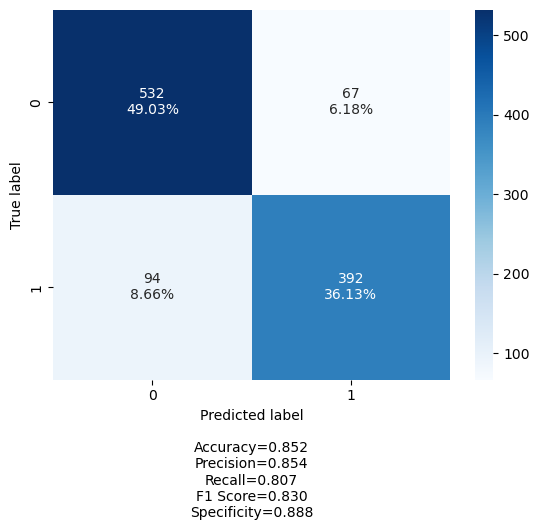

In [86]:
test(data_val_600_dl)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Test on dataset with length less than 215 </div>

In [ ]:
PATH = "ResidualNN_215.pth"

model = ResidualNN()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
test(data_val_215_dl)

# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Test on dataset cut around the mutation with different length </div>

In [ ]:
VAL_CUT_5 = NEW + "val_cut_5.csv"
VAL_CUT_10 = NEW + "val_cut_10.csv"
VAL_CUT_20 = NEW + "val_cut_20.csv"
VAL_CUT_50 = NEW + "val_cut_50.csv"

In [ ]:
data_val_cut_5 = pd.read_csv(VAL_CUT_5)
data_val_cut_10 = pd.read_csv(VAL_CUT_10)
data_val_cut_20 = pd.read_csv(VAL_CUT_20)
data_val_cut_50 = pd.read_csv(VAL_CUT_50)

In [ ]:
data_val_cut_5_ds = ProteinDataset(data_val_cut_5, VAL_CUT_5, SEQUENCE_215, transform=transfrom_data)
data_val_cut_10_ds = ProteinDataset(data_val_cut_10, VAL_CUT_10, SEQUENCE_215, transform=transfrom_data)
data_val_cut_20_ds = ProteinDataset(data_val_cut_20, VAL_CUT_20, SEQUENCE_215, transform=transfrom_data)
data_val_cut_50_ds = ProteinDataset(data_val_cut_50, VAL_CUT_50, SEQUENCE_215, transform=transfrom_data)

In [ ]:
data_val_cut_5_dl = DataLoader(data_val_cut_5_ds, batch_size = 1)
data_val_cut_10_dl = DataLoader(data_val_cut_10_ds, batch_size = 1)
data_val_cut_20_dl = DataLoader(data_val_cut_20_ds, batch_size = 1)
data_val_cut_50_dl = DataLoader(data_val_cut_50_ds, batch_size = 1)

In [ ]:
test(data_val_cut_5_dl)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success"> 2.3 |</span></b> Classification technique : Convolutional Neural Network </div>

## CNN

## Residual NN 

# Model 3 